In [384]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [385]:
# importar todas las librerias necesarias
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [386]:
# Lectura de Data de entrenamiento y test

data = pd.read_csv('alturas-pesos-mils-train.csv')[:-1]

test = pd.read_csv('alturas-pesos-mils-test.csv')

data_hombres = data.loc[data['Genero'] == 'Hombre'][['Peso', 'Altura']].values

data_mujeres = data.loc[data['Genero'] == 'Mujer'][['Peso', 'Altura']].values

**Analisis Estadistico: Aplicación Manual de LDA**

In [387]:
from scipy.stats import multivariate_normal

In [388]:
# Función para obtener la probabilidad de un dato de pertenecer a una clase (Hombre o Mujer)
def get_gauss_prob(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    data_np = data
    likelihood_class_1 = multivariate_normal.pdf(data_np, mean_hombres, cov_hombres)
    likelihood_class_2 = multivariate_normal.pdf(data_np, mean_mujeres, cov_mujeres)
    N_class_1 = len(data_hombres)
    N_class_2 = len(data_mujeres)
    prior_1 = N_class_1/(N_class_1 + N_class_2)
    prior_2 = N_class_2/(N_class_1 + N_class_2)
    total = likelihood_class_1 * prior_1 + likelihood_class_2 * prior_2
    p_class_1 = likelihood_class_1 * prior_1/total
    p_class_2 = likelihood_class_2 * prior_2/total
    return p_class_1, p_class_2


In [389]:
# Función para obtener la precisión de la clasificación
def get_acc_gauss(data, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres):
    p_class_1, p_class_2 = get_gauss_prob(data[['Peso', 'Altura']].values, mean_hombres, mean_mujeres, cov_hombres, cov_mujeres)
    return ((p_class_1>p_class_2)==(data['Genero']=='Hombre')).sum()/len(p_class_1)

In [390]:
# Este es literalmente todo el entrenamiento requerido para la clasificacion entre hombres y mujeres.
# MLE se aplica tanto para la matriz de covarianza y el mean de hombres y mujeres.
# El resultado de dicha aplicación es la matriz de covarianza y el mean de hombres y mujeres. 
# (Que en conjunto representa el vector media y la matriz de covarianza de la distribución Gaussiana de los datos de entrenamiento)
mean_hombres = data_hombres.mean(axis=0)
mean_mujeres = data_mujeres.mean(axis=0)
cov_LDA = np.cov(np.vstack([data_hombres - mean_hombres, data_mujeres - mean_mujeres]).T)

In [391]:
print(cov_LDA)
print(np.cov(data_mujeres.T))

[[77.94597261 53.52970001]
 [53.52970001 50.2964779 ]]
[[75.19882927 50.77709625]
 [50.77709625 47.57064786]]


In [392]:
# Accuracy de entrenamiento y test
acc_train_LDA =  get_acc_gauss(data, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)
acc_test_LDA = get_acc_gauss(test, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)

print(acc_train_LDA)
print(acc_test_LDA)

0.9167395924490561
0.9225


**IMPLEMENTACION MEDIANTE SKLEARN**

In [393]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [394]:
LDA_clf = LinearDiscriminantAnalysis(store_covariance=True, solver='eigen')
LDA_clf.fit(data[['Peso', 'Altura']], data['Genero'])
acc_train_sklearn = LDA_clf.score(data[['Peso', 'Altura']], data['Genero'])
acc_test_sklearn = LDA_clf.score(test[['Peso', 'Altura']], test['Genero'])
print(acc_train_sklearn)
print(acc_test_sklearn)

0.9167395924490561
0.9225


**COMPARACION DE ACCURACIES Y PARAMETROS**

In [395]:
delta_acc_train = abs(acc_train_LDA - acc_train_sklearn)
delta_acc_test = abs(acc_test_LDA - acc_test_sklearn)
print(delta_acc_train)
print(delta_acc_test)

0.0
0.0


In [396]:
delta_mean_hombres = abs(mean_hombres - LDA_clf.means_[0])
delta_mean_mujeres = abs(mean_mujeres- LDA_clf.means_[1])
delta_cov = abs(cov_LDA - LDA_clf.covariance_)
print("D-Mean mujeres: " + str(delta_mean_hombres))
print("D-Mean Hombres: " + str(delta_mean_mujeres))
print("Delta Cov Matrix: ")
print(str(delta_cov))

print(LDA_clf.intercept_)

D-Mean mujeres: [1.27897692e-13 3.41060513e-13]
D-Mean Hombres: [4.97379915e-14 2.84217094e-14]
Delta Cov Matrix: 
[[0.00974446 0.00669205]
 [0.00669205 0.00628785]]
[0.80987711]


**VISUALIZACION DE DATOS (LDA MANUAL)**

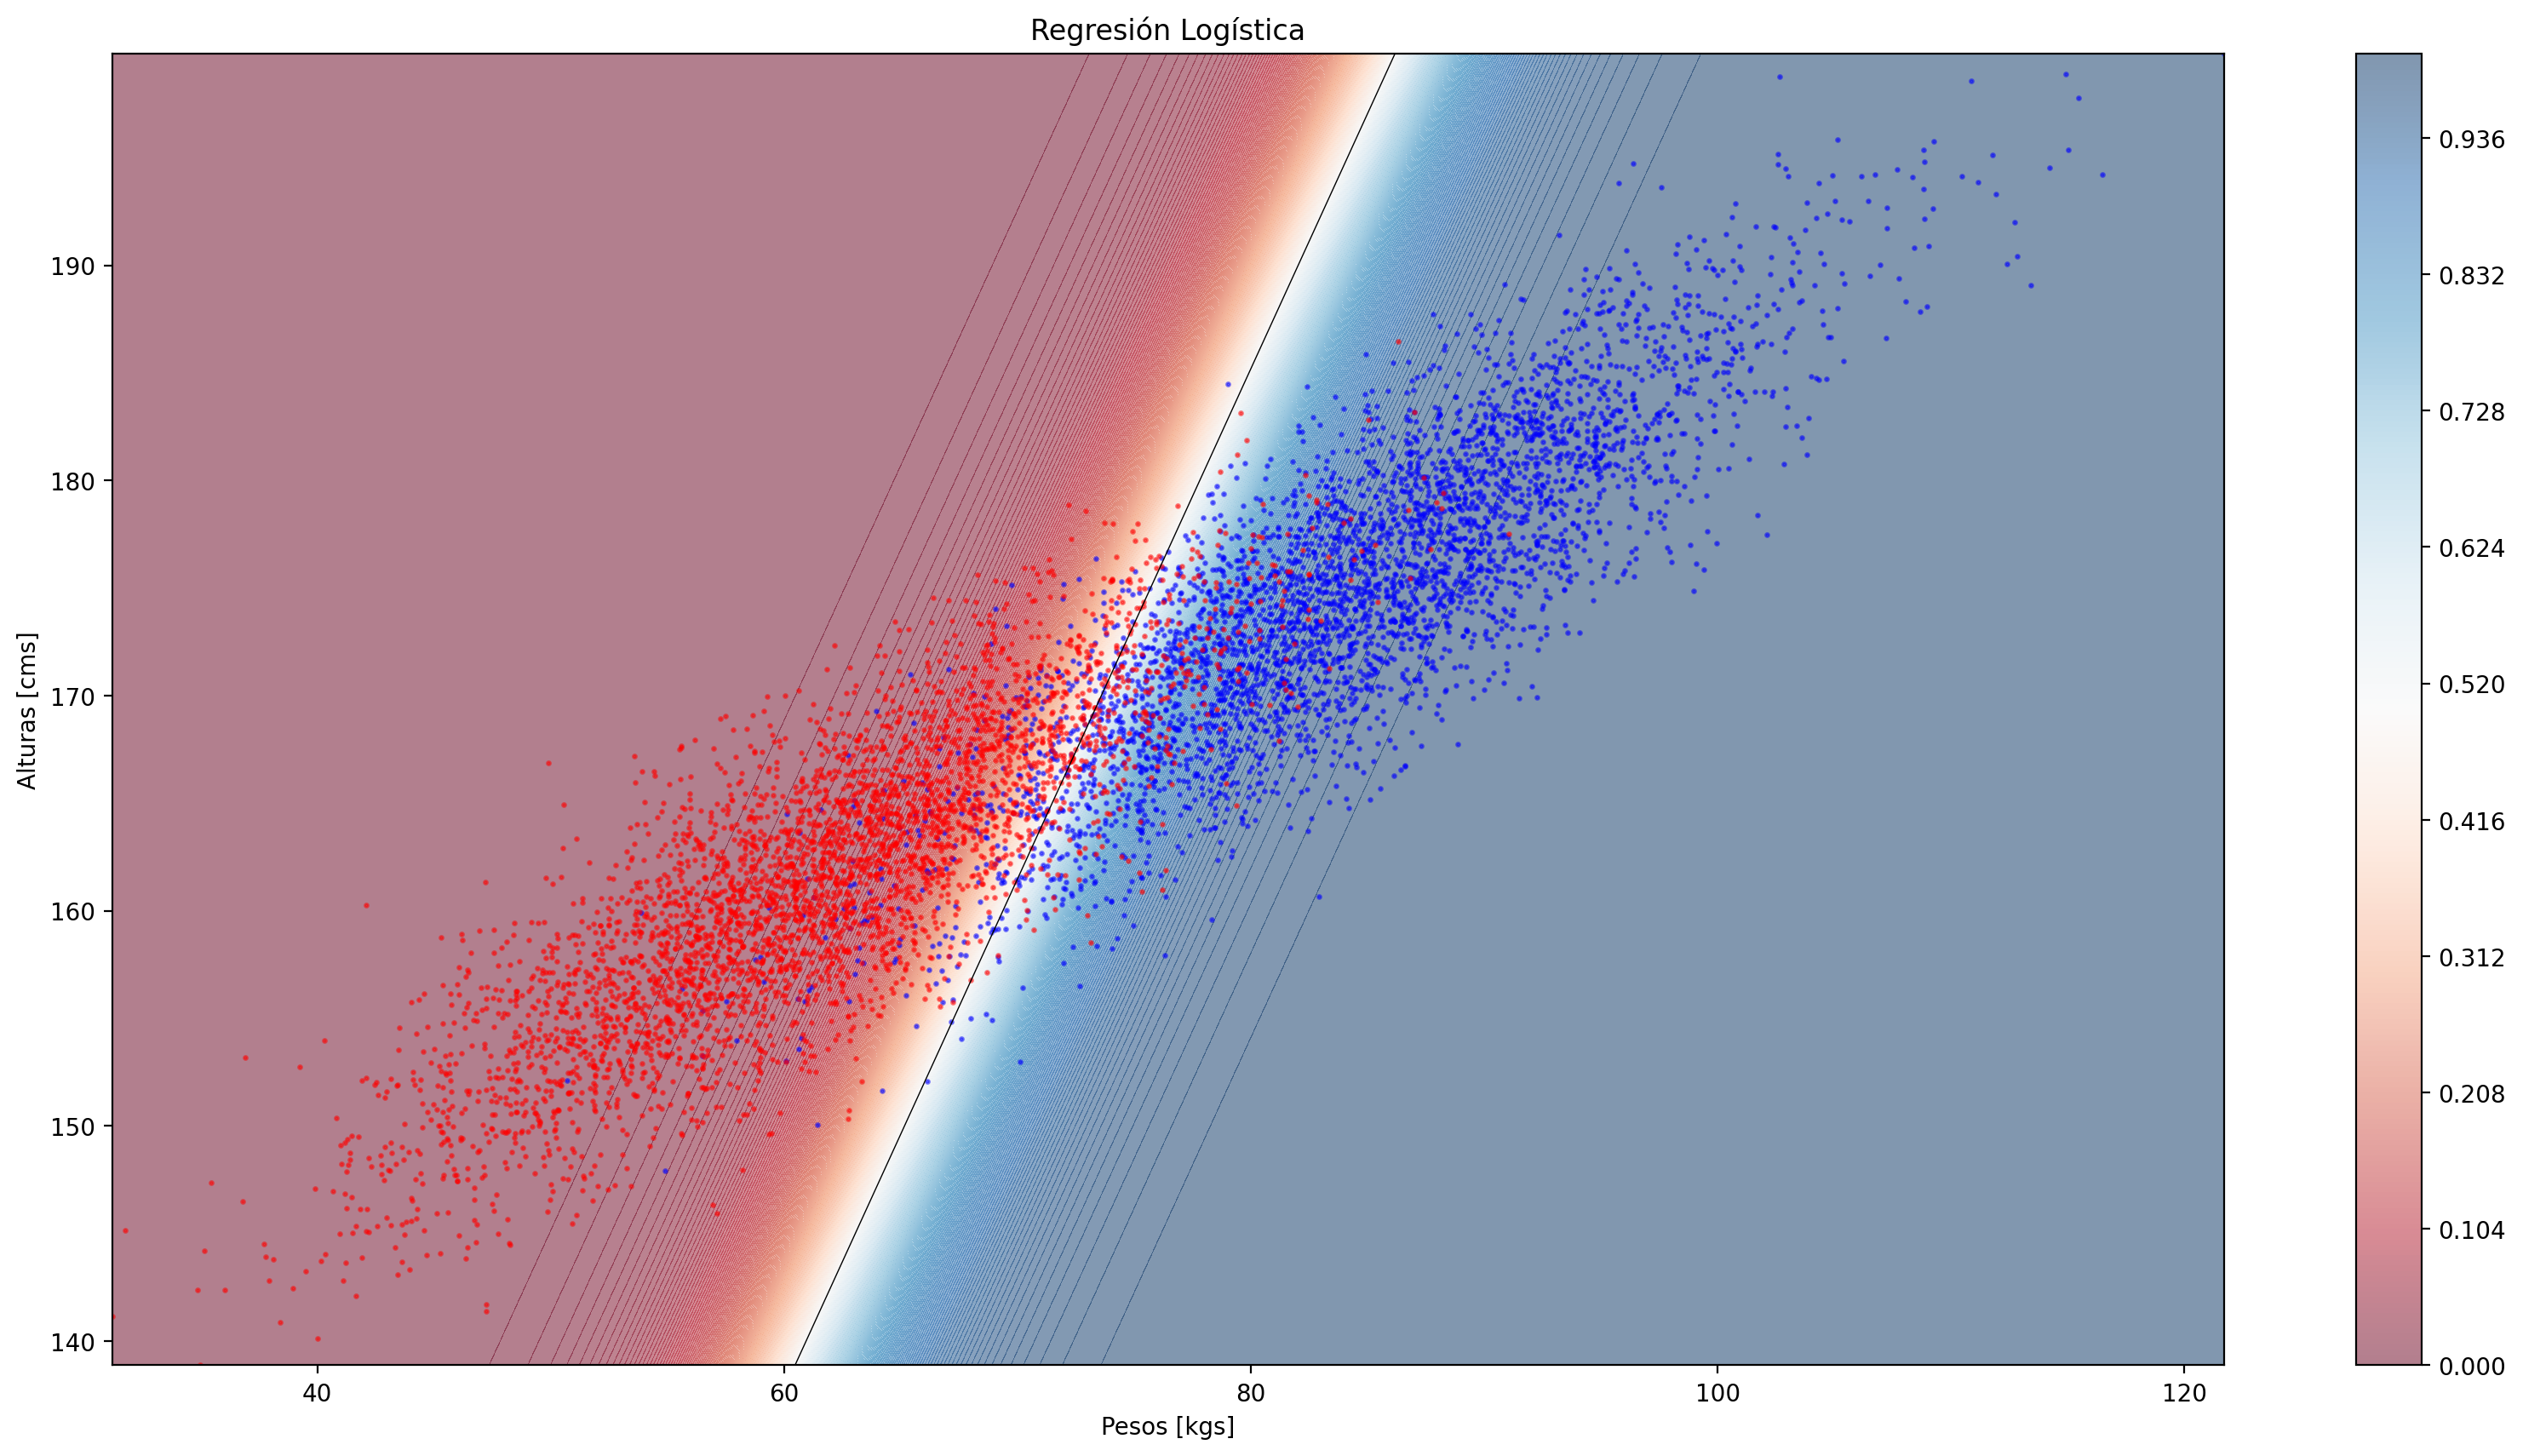

In [397]:
N=300
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
X = np.linspace(data.min()['Peso'], data.max()['Peso'], N)
Y = np.linspace(data.min()['Altura'], data.max()['Altura'], N)
X, Y = np.meshgrid(X, Y)
# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
Z, a = get_gauss_prob(pos, mean_hombres, mean_mujeres, cov_LDA, cov_LDA)
cf = ax.contourf(X, Y, Z, 256, alpha=.5, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
ax.contour(X, Y, Z, (0.5,), colors='k', linewidths=0.5)
plt.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, alpha=0.5)
plt.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, alpha=0.5)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.title('Regresión Logística')
plt.show()

In [398]:
# Quadratic Data Extension
data['Peso_squared'] = data['Peso']**2

data['Altura_squared'] = data['Altura']**2

data['Peso_Altura_interaction'] = data['Peso'] * data['Altura']

test['Peso_squared'] = test['Peso']**2

test['Altura_squared'] = test['Altura']**2

test['Peso_Altura_interaction'] = test['Peso'] * test['Altura']

# Quadratic Data extension, binary categorized. (Hombre / Mujer)

data_hombres = data.loc[data['Genero'] == 'Hombre'][['Peso', 'Altura', 'Peso_squared','Altura_squared', 'Peso_Altura_interaction' ]].values
data_mujeres = data.loc[data['Genero'] == 'Mujer'][['Peso', 'Altura', 'Peso_squared','Altura_squared', 'Peso_Altura_interaction' ]].values

# Verificación de correcta extension cuadratica.
print(data_hombres)

[[   97.432      181.908     9492.994624 33090.520464 17723.660256]
 [   73.324      172.459     5376.408976 29742.106681 12645.383716]
 [   77.618      172.705     6024.553924 29827.017025 13405.01669 ]
 ...
 [   92.479      176.934     8552.365441 31305.640356 16362.679386]
 [   83.84       177.866     7029.1456   31636.313956 14912.28544 ]
 [   75.461      170.91      5694.362521 29210.2281   12897.03951 ]]


In [399]:
#Accuracy de Training y de Testeo
LDA_clf = LinearDiscriminantAnalysis(store_covariance=True)
LDA_clf.fit(data[['Peso', 'Altura', 'Peso_squared','Altura_squared', 'Peso_Altura_interaction' ]], data['Genero'])
acc_train_sklearn = LDA_clf.score(data[['Peso', 'Altura', 'Peso_squared','Altura_squared', 'Peso_Altura_interaction' ]], data['Genero'])
acc_test_sklearn = LDA_clf.score(test[['Peso', 'Altura', 'Peso_squared','Altura_squared', 'Peso_Altura_interaction' ]], test['Genero'])
print(acc_train_sklearn)
print(acc_test_sklearn)
LDA_clf

0.9157394674334292
0.92


LinearDiscriminantAnalysis(store_covariance=True)

c:\Users\santi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


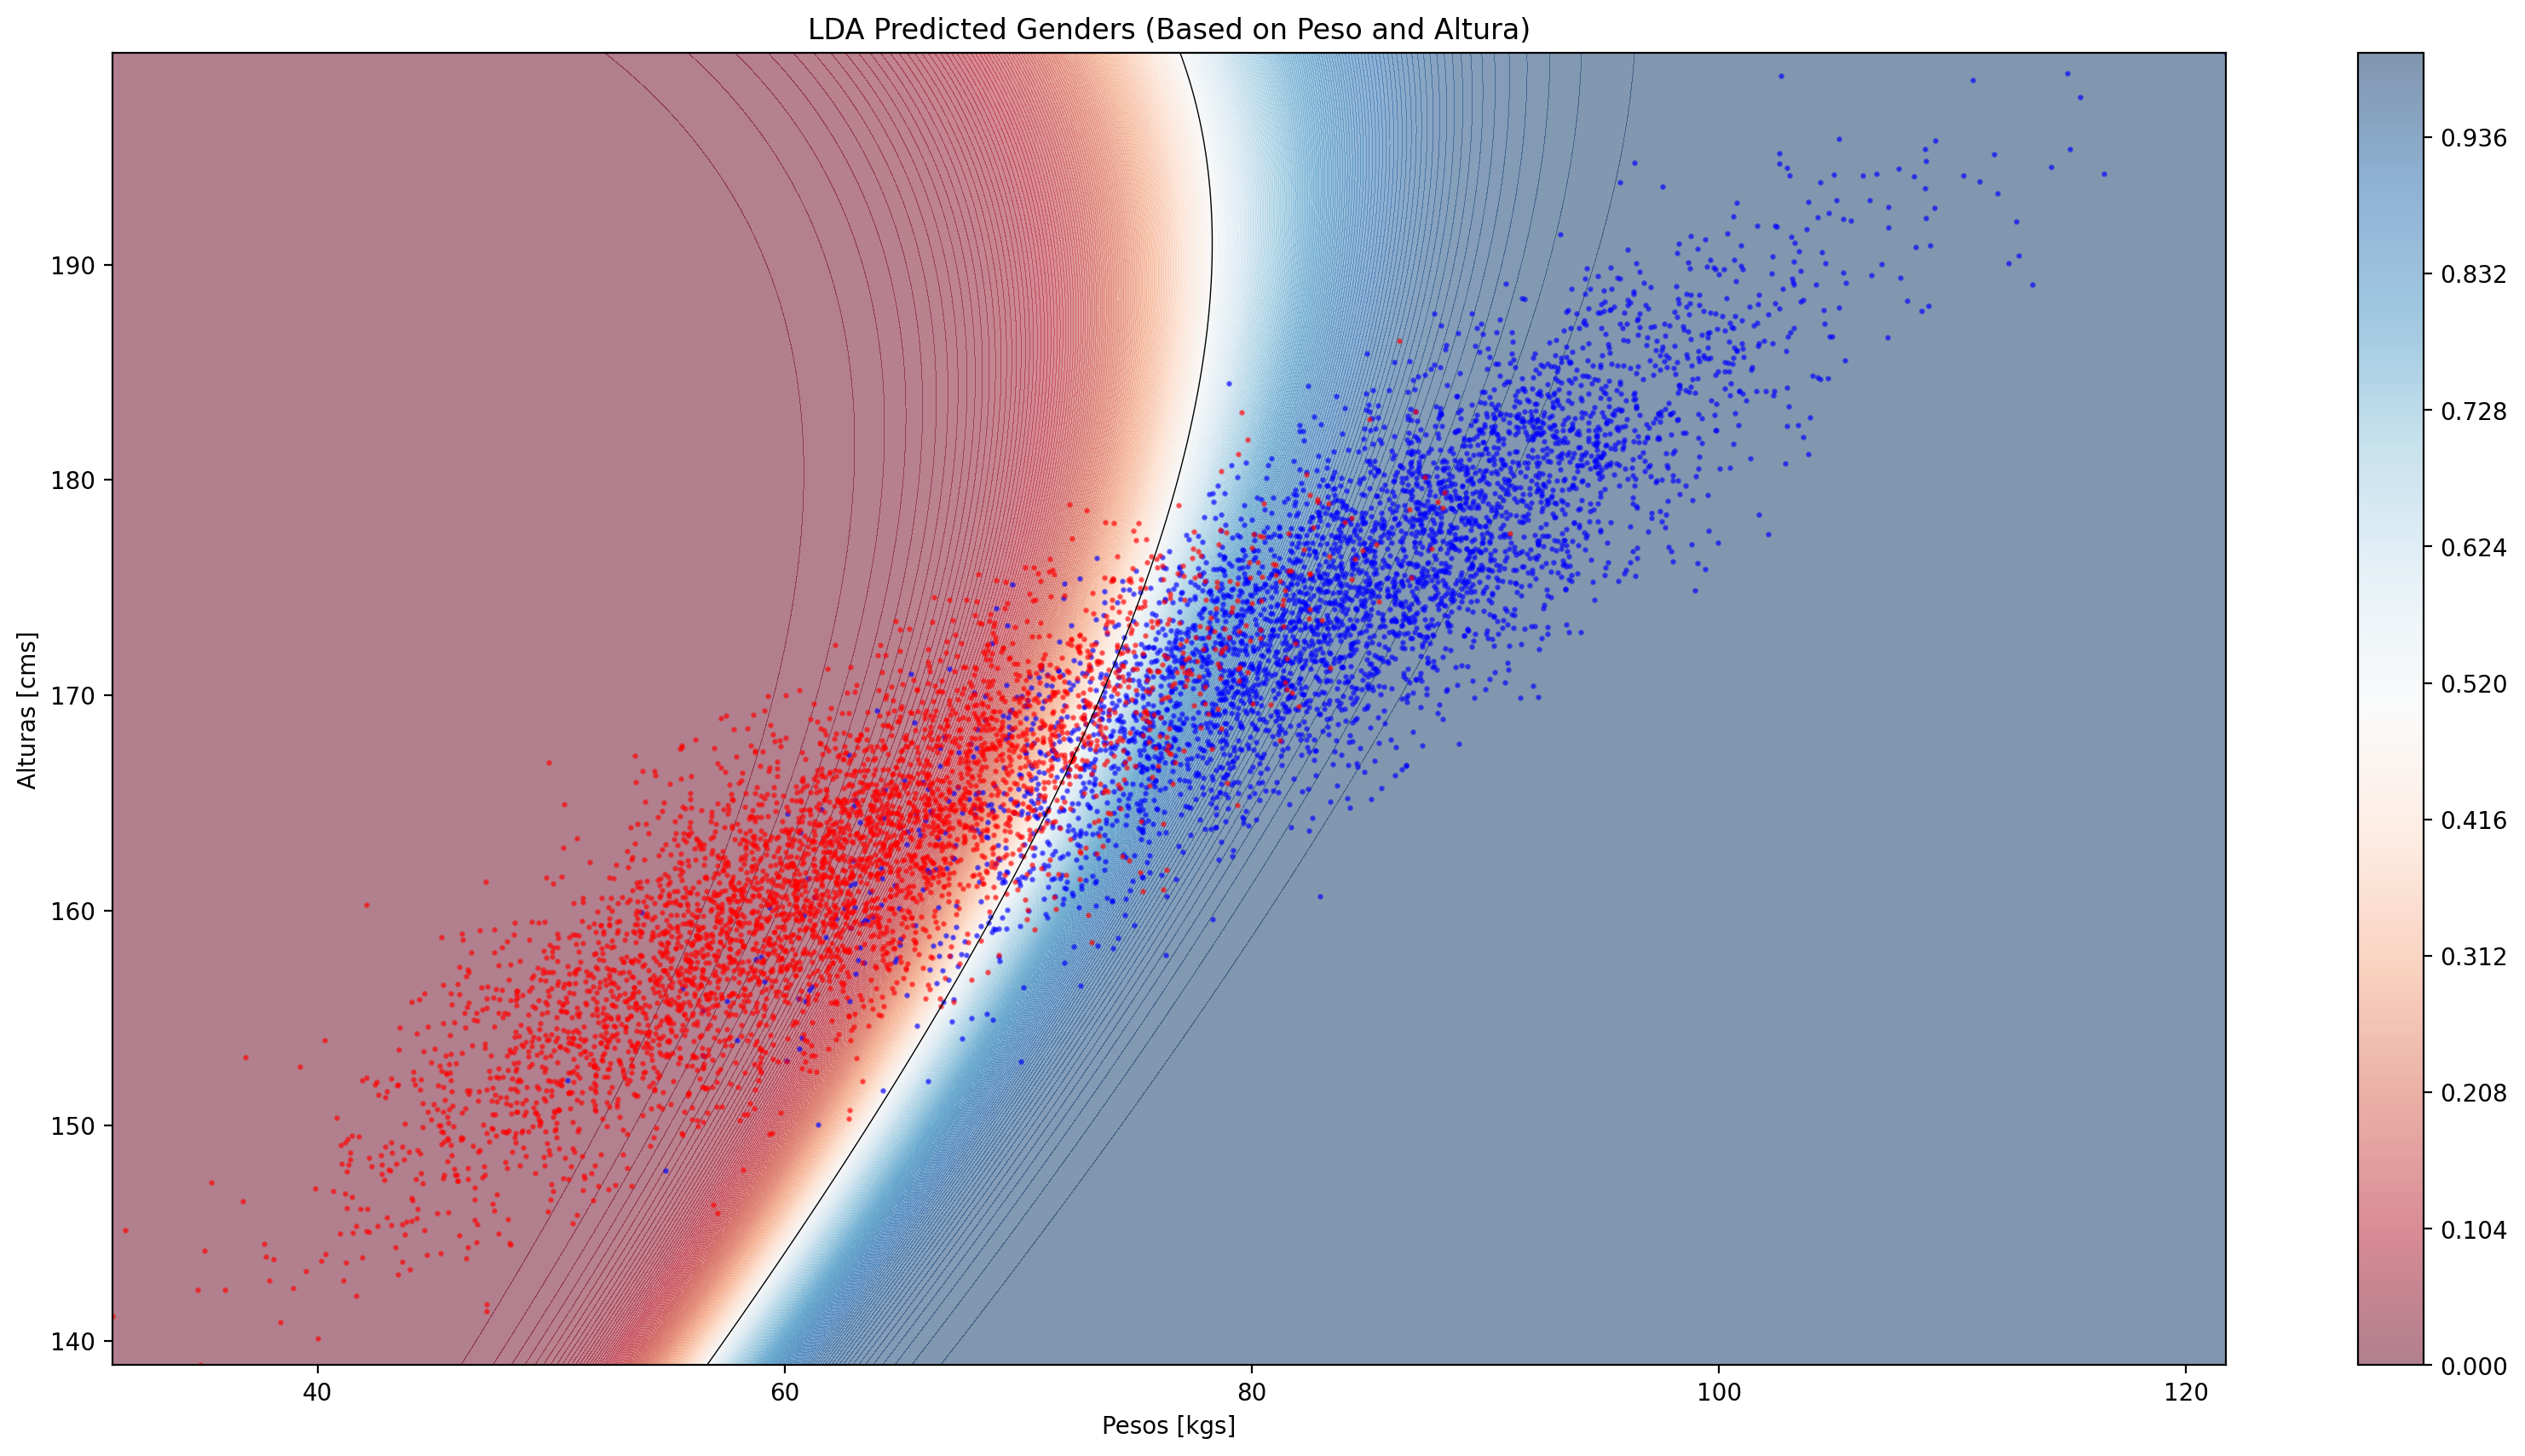

In [400]:
# Prepare data for LDA
X_train = data[['Peso', 'Altura', 'Peso_squared', 'Altura_squared', 'Peso_Altura_interaction']]
y_train = data['Genero']

# Train LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Create meshgrid for prediction (using original features)
N = 300
X_grid = np.linspace(data['Peso'].min(), data['Peso'].max(), N)
Y_grid = np.linspace(data['Altura'].min(), data['Altura'].max(), N)
X_mesh, Y_mesh = np.meshgrid(X_grid, Y_grid)

# Prepare input for prediction (using extended features from meshgrid)
X_predict = np.c_[X_mesh.ravel(), Y_mesh.ravel(), X_mesh.ravel()**2, Y_mesh.ravel()**2, (X_mesh * Y_mesh).ravel()]

# Predict genders (using extended features)
Z = lda.predict_proba(X_predict)[:, 0].reshape(X_mesh.shape) # Probability of 'Mujer'

# Plotting
fig = plt.figure(figsize=(20, 10))
ax = fig.gca()
cm = plt.cm.RdBu

cf = ax.contourf(X_mesh, Y_mesh, Z, 256, alpha=0.5, vmin=0., vmax=1., cmap=cm)
plt.colorbar(cf, ax=ax)
ax.contour(X_mesh, Y_mesh, Z, (0.5,), colors='k', linewidths=0.5)

# Original data points (using original features)
data_hombres = data.loc[data['Genero'] == 'Hombre'][['Peso', 'Altura']].values
data_mujeres = data.loc[data['Genero'] == 'Mujer'][['Peso', 'Altura']].values
plt.scatter(data_hombres[:, 0], data_hombres[:, 1], color='b', s=2, alpha=0.5)
plt.scatter(data_mujeres[:, 0], data_mujeres[:, 1], color='r', s=2, alpha=0.5)

ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
plt.title('LDA Predicted Genders (Based on Peso and Altura)')
plt.show()

**El umbral de decisión sigue siendo lineal?** 
Si. Estrictamente en terminos matematicos, la ecuacion continua siendo X*W + C = 0.
Sin embargo, las nuevas dimensiones parametrizadas que utilizamos, son en realidad combinaciones algebraicas de las dos previamente utilizadas. La funcion final X*W + C = 0, no depende linealmente unicamente de p y a. Si no que dependen cuadraticamente de las mismas. Este metodo se utiliza frecuentemente para extender el espacio de busqueda del modelo probabilistico lineal. Encontrando relaciones cuadraticas intra e inter relacionadas entre el peso y la altura de cada uno.

**¿Cuántos parámetros tiene el modelo ahora?**
Existe una unica matriz de covarianza que representa la curva continua gaussiana n-dimensional. Asi mismo, la constante continua siendo 1-dimensional. Finalmente, el vector valor esperado, aumenta en 4 dimensiones, considerando las nuevas entradas provistas por la extension cuadratica.

**¿Cuántos parámetros tenía antes?**
La misma cantidad de parametros: Matriz Covarianza, Vector Valor esperado, y la constante de intercepcion provista por la ecuacion X*W + C = 0.

**¿Cómo dan las métricas de train y validación?**
Las metricas de validacion son:
